# Bang-Singular-Bang problem and turnpike

* Author: Olivier Cots
* Date: November 2021

------

## I) Description of the optimal control problem

We consider the following optimal control problem:

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \int_0^{t_f} x^2(t) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) = f(x(t), u(t)) := \displaystyle u(t), \quad  |u(t)| \le 1, \quad t \in [0, t_f] \text{ a.e.},    \\[1.0em]
        x(0) = 1, \quad x(t_f) = 1/2.
    \end{array}
    \right. 
$$

To this optimal control problem is associated the stationnary optimization problem

$$
    \min_{(x, u)} \{~ x^2 ~ | ~  (x, u) \in \mathrm{R} \times [-1, 1],~ f(x,u) = u = 0\}.
$$

The static solution is thus $(x^*, u^*) = (0, 0)$. This solution may be seen as the static pair $(x, u)$ which minimizes the cost $J(u)$ under
the constraint $u \in [-1, 1]$.
It is well known that this problem is what we call a *turnpike* optimal control problem.
Hence, if the final time $t_f$ is long enough the solution is of the following form: 
starting from $x(0)=1$, reach as fast as possible the static solution, stay at the static solution as long as possible before reaching
the target $x(t_f)=1/2$. In this case, the optimal control would be

$$
    u(t) = \left\{ 
    \begin{array}{lll}
        -1            & \text{if} & t \in [0, t_1],     \\[0.5em]
        \phantom{-}0  & \text{if} & t \in (t_1, t_2],   \\[0.5em]
        +1            & \text{if} & t \in (t_2, t_f],
    \end{array}
    \right. 
$$

with $0 < t_1 < t_2 < t_f$. We say that the control is *Bang-Singular-Bang*. A Bang arc corresponds to $u \in \{-1, 1\}$ while a singular control corresponds to $u \in (-1, 1)$. Since the optimal control law is discontinuous, then to solve this optimal control problem by indirect methods and find the *switching times* $t_1$ and $t_2$, we need to implement what we call a *multiple shooting method*. In the next section we introduce a regularization technique to force the control to be in the set $(-1,1)$ and to be smooth. In this context, we will be able to implement a simple shooting method and determine the structure of the optimal control law. Thanks to the simple shooting method, we will have the structure of the optimal control law together with an approximation of the switching times that we will use as initial guess for the multiple shooting method that we present in the last section.

<div class="alert alert-warning">

**Main goal**

Find the switching times $t_1$ and $t_2$ by multiple shooting.
    
</div>

Steps:

1. Regularize the problem and solve the regularized problem by simple shooting.
2. Determine the structure of the non-regularized optimal control problem, that is the structure Bang-Singular-Bang, and find a good approximation of the switching times and of the initial co-vector.
3. Solve the non-regularized optimal control problem by multiple shooting.

**_Remark 1._** See this [page](https://ct.gitlabpages.inria.fr/gallery/shooting_tutorials/simple_shooting_general.html) for a general presentation of the simple shooting method.

**_Remark 2._** In this particular example, the singular control does not depend on the costate $p$ since it is constant. This happens in low dimension. This could be taken into consideration to simplify the definition of the multiple shooting method. However, to stay general, we will not consider this particular property in this notebook.  


## II) Regularization and simple shooting

We make the following regularization:

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \int_0^{t_f} (x^2(t) - \varepsilon\ln(1-u^2(t))) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) = f(x(t), u(t)) := \displaystyle u(t), \quad  |u(t)| \le 1, \quad t \in [0, t_f] \text{ a.e.},    \\[1.0em]
        x(0) = 1, \quad x(t_f) = 1/2.
    \end{array}
    \right. 
$$

Our goal is to determine the structure of the optimal control problem when $(\varepsilon, t_f) = (0, 2)$. The problem is simpler to solver when $\varepsilon$ is bigger and $t_f$ is smaller. It is also smooth whenever $\varepsilon>0$. Hence, we will start by solving the problem for $(\varepsilon, t_f) = (1, 1)$. In a second step, we will decrease the *penalization term* $\varepsilon$ and increase the final time $t_f$ to the final value $2$.

This problem is still a turnpike control problem but for $\varepsilon>0$, the optimal control is smooth since the strict Legendre-Clebsch condition will be satisfied under this assumption. For $\varepsilon>0$, the stationnary solution is still $(x, u) = (0, 0)$ and the associated Lagrange multiplier is $p=0$. Hence, we are going to start by solving the regularized optimal control problem with the limit conditions $x(0)=x(t_f)=0$. This particular case amounts to solve the stationnary optimization problem for which the optimal solution is known. 

### Preliminaries

In [1]:
# import packages
import nutopy as nt
import nutopy.tools as tools
import nutopy.ocp as ocp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['figure.dpi'] = 100

In [2]:
# Finite differences function
# Return f'(x).dx
def finite_diff(fun, x, dx, *args, **kwargs):
    v_eps = np.finfo(float).eps
    t = np.sqrt(v_eps) * np.sqrt(np.maximum(1.0, np.linalg.norm(x))) / np.sqrt(np.maximum(1.0, np.linalg.norm(dx)))
    j = (fun(x + t*dx, *args, **kwargs) - fun(x, *args, **kwargs)) / t
    return j

In [3]:
# Compilation of the hamiltonian and associated derivatives up to order 2

!python -m numpy.f2py -c hfun.f90       -m hfun       > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90     -m hfun_d     > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90   -m hfun_d_d   > /dev/null 2>&1

from hfun       import hfun       as hf
from hfun_d     import hfun_d     as hf_d
from hfun_d_d   import hfun_d_d   as hf_d_d

In [4]:
# Parameters

t0        = 0.0
x0        = np.array([1.0])
xf_target = np.array([0.5])

x_steady  = np.array([0.0+0.001]) # solution of stationnary problem + epsilon

e_init    = 1.0
e_final   = 0.001 #

tf_init   = 1.0 # With this value the problem is simpler to solver since the trajectory stay 
                # less time around the static solution
tf_final  = 2.0

### Maximized Hamiltonian and its derivatives

The pseudo-Hamiltonian is (in the normal case)

$$
    H(x,p,u,\varepsilon) = pu - x^2 + \varepsilon ln(1-u^2).
$$

Note that we put the parameter $\varepsilon$ into the arguments of the pseudo-Hamiltonian since we will vary it.

In [5]:
# Fortran Hamiltonian code
!pygmentize hfun.f90

subroutine hfun(x, p, e, h)

    double precision, intent(in)  :: x(1), p(1), e
    double precision, intent(out) :: h

    double precision :: u
    
    if(abs(p(1))<1e-8)then
        u = 0d0
    else
        u = (-e + sqrt(e**2+p(1)**2))/p(1)
    end if
        
    h = p(1)*u - x(1)**2 + e*(log(1d0-u**2))
    
end subroutine hfun


In [6]:
# Control in feedback form u[p,e].
#
@tools.vectorize(vvars=(1,))
def ufun(p, e):
    if(np.abs(p[0])<1e-8):
        u = 0.
    else:
        u = (-e + np.sqrt(e**2+p[0]**2))/p[0]
    return u

We give next the maximized Hamiltonian with its derivatives. This permits us to define the flow of the associated Hamiltonian vector field.

In [7]:
# Hamiltonian and derivatives
hfun   = lambda t, x, p, e                : hf(x, p, e)
dhfun  = lambda t, x, dx, p, dp, e, de    : hf_d(x, dx, p, dp, e, de)
d2hfun = lambda t, x, dx, d2x, p, dp, d2p, e, de, d2e : hf_d_d(x, d2x, dx, p, d2p, dp, e, d2e, de)

hfun   = nt.tools.tensorize(dhfun, d2hfun, tvars=(2, 3, 4), full=True)(hfun)
h      = nt.ocp.Hamiltonian(hfun)

f = ocp.Flow(h)             # The flow associated to the Hamiltonian object is 
                            # the exponential mapping with its derivative
                            # that can be used to define the Jacobian of the 
                            # shooting function

### Shooting function and its derivative

The shooting function is

$$
 S(x_\mathrm{mid}, p_\mathrm{mid}) := 
 \begin{pmatrix}
     x(t_0, (t_0+t_f)/2, x_\mathrm{mid}, p_\mathrm{mid}, \varepsilon) - x_0       \\
     x(t_f, (t_0+t_f)/2, x_\mathrm{mid}, p_\mathrm{mid}, \varepsilon) - x_f
 \end{pmatrix},
$$

where $t_f = 1$, $\varepsilon = 1$, $x_0=x^*$, $x_f=x^*$, $x^* = 0$ (the steady state) and 
where $z(t_f, t_0, x_0, p_0, \varepsilon)$ is the solution of the associated Hamiltonian system with the initial condition $z(t_0) = (x_0, p_0)$.

<div class="alert alert-warning">

**Procedure**

First solve $S=0$ then use homotopy techniques to converge towards the solution of the original problem.
    
</div>

**_Remark:_** This first shooting is useless since we know the solution. We do it for illustration and validation.

In [8]:
# Definition of the shooting function
#
def shoot(zmid):
    s      = np.zeros((2,))
    x12    = zmid[0:1]
    p12    = zmid[1:2]
    xf, pf = f((t0+tf_init)/2., x12, p12, tf_init, e_init)
    xi, pi = f((t0+tf_init)/2., x12, p12,      t0, e_init)
    s[0]   = xf[0] - x_steady[0]
    s[1]   = xi[0] - x_steady[0]
    return s

In [9]:
# Derivative of the shooting function
#
def dshoot(zmid, dzmid):
    ds     = np.zeros((2,))
    x12    = zmid[0:1]
    p12    = zmid[1:2]
    dx12   = dzmid[0:1]
    dp12   = dzmid[1:2]
    (xf, dxf), _ = f((t0+tf_init)/2., (x12, dx12), (p12, dp12), tf_init, e_init)
    (xi, dxi), _ = f((t0+tf_init)/2., (x12, dx12), (p12, dp12),      t0, e_init)
    ds[0]  = dxf[0]
    ds[1]  = dxi[0]
    return ds

shoot = nt.tools.tensorize(dshoot, tvars=(1,))(shoot)

In [10]:
# Function to plot the solution
def plotSolution(zmid, e, tf):
    
    x12     = zmid[0:1]
    p12     = zmid[1:2]
    
    N       = 100
    
    tspanf  = list(np.linspace((t0+tf)/2, tf, N+1))
    tspani  = list(np.linspace((t0+tf)/2, t0, N+1))
        
    xf, pf = f((t0+tf)/2., x12, p12, tspanf, e)
    xi, pi = f((t0+tf)/2., x12, p12, tspani, e)
    
    uf     = ufun(pf, e)
    ui     = ufun(pi, e)

    fig = plt.figure()
    
    ax  = fig.add_subplot(131);
    ax.set_xlabel('t'); ax.set_ylabel('$x$'); 
    ax.axhline(0, color='k', linewidth=0.5); ax.axvline( 0, color='k', linewidth=0.5); ax.axvline( tf, color='k', linewidth=0.5)
    ax.plot(np.concatenate((np.flip(tspani), tspanf)), np.concatenate((np.flip(xi), xf)))
    
    ax  = fig.add_subplot(132);
    ax.set_xlabel('t'); ax.set_ylabel('$p$'); 
    ax.axhline(0, color='k', linewidth=0.5); ax.axvline( 0, color='k', linewidth=0.5); ax.axvline( tf, color='k', linewidth=0.5)
    ax.plot(np.concatenate((np.flip(tspani), tspanf)), np.concatenate((np.flip(pi), pf)))
   
    ax  = fig.add_subplot(133);
    ax.set_xlabel('t'); ax.set_ylabel('$u$'); 
    ax.axhline(0, color='k', linewidth=0.5); ax.axvline( 0, color='k', linewidth=0.5); ax.axvline( tf, color='k', linewidth=0.5)
    ax.axhline(-1, color='k', linewidth=0.5)
    ax.axhline( 1, color='k', linewidth=0.5)
    ax.plot(np.concatenate((np.flip(tspani), tspanf)), np.concatenate((np.flip(ui), uf)))

### Resolution of the regularized problem

In [11]:
# Shooting for (tf, e) = (tf_init, e_init)
p0_guess = np.array([x_steady[0], 0.0])
sol_nle  = nt.nle.solve(shoot, p0_guess, df=shoot)


     Calls  |f(x)|                 |x|
 
         1  1.804903493012030e-04  1.000000000000000e-03
         2  8.904124663136239e-13  8.868188925481338e-04
         3  2.168404344971009e-19  8.868188931064897e-04

 Results of the nle solver method:

 xsol    =  [ 8.86818893e-04 -4.17259936e-19]
 f(xsol) =  [-2.16840434e-19  0.00000000e+00]
 nfev    =  3
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.



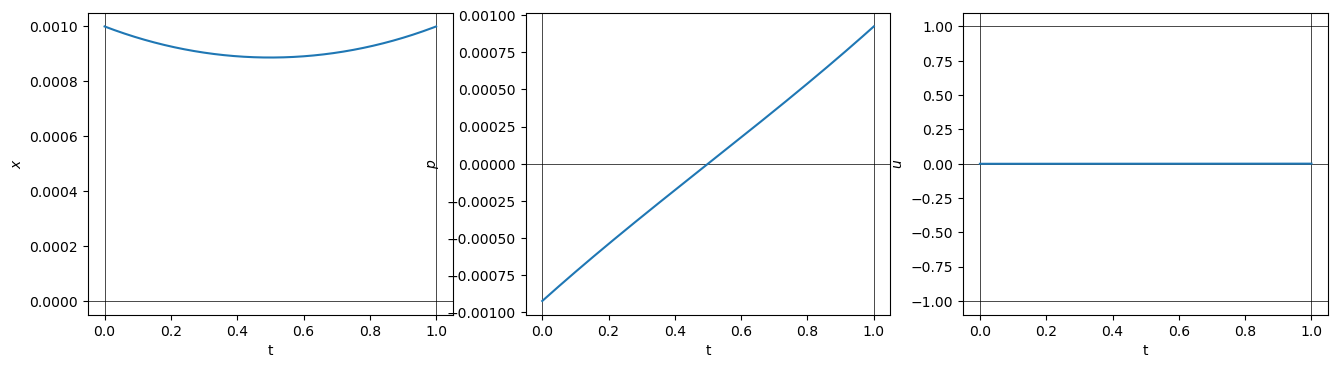

In [12]:
# Plot solution for (tf, e) = (tf_init, e_init)
plotSolution(sol_nle.x, e_init, tf_init)

In [13]:
# Definition of the homotopic function and its first order derivative
# This function is used to solve S=0 for different values of e=epsilon and tf.
def dhomfun(x12, dx12, p12, dp12, x0, dx0, xf_target, dxf_target, e, de, tf, dtf):
    s      = np.zeros((2,))
    ds     = np.zeros((2,))
    (xf, dxf), _ = f(((t0+tf)/2., dtf/2.), (x12, dx12), (p12, dp12), (tf, dtf), (e, de))
    (xi, dxi), _ = f(((t0+tf)/2., dtf/2.), (x12, dx12), (p12, dp12), t0, (e, de))
    s[0]   = xf[0] - xf_target[0]
    s[1]   = xi[0] - x0[0]
    ds[0]  = dxf[0] - dxf_target[0]
    ds[1]  = dxi[0] - dx0[0]
    return s, ds

@tools.tensorize(dhomfun, tvars=(1, 2, 3, 4, 5, 6), full=True)
def homfun(x12, p12, x0, xf_target, e, tf):
    s      = np.zeros((2,))
    xf, _  = f((t0+tf)/2., x12, p12, tf, e)
    xi, _  = f((t0+tf)/2., x12, p12, t0, e)
    s[0]   = xf[0] - xf_target[0]
    s[1]   = xi[0] - x0[0]
    return s

#
def dfoo(zmid, dzmid, par, dpar):
    x12 = zmid[0:1]
    p12 = zmid[1:2]
    x0  = par[0:1]
    xf_target = par[1:2]
    e   = par[2]
    tf  = par[3]
    dx12 = dzmid[0:1]
    dp12 = dzmid[1:2]
    dx0  = dpar[0:1]
    dxf_target = dpar[1:2]
    de   = dpar[2]
    dtf  = dpar[3]
    return homfun((x12, dx12), (p12, dp12), (x0, dx0), (xf_target, dxf_target), (e, de), (tf, dtf))

@tools.tensorize(dfoo, tvars=(1, 2), full=True)
def foo(zmid, par):
    x12 = zmid[0:1]
    p12 = zmid[1:2]
    x0  = par[0:1]
    xf_target = par[1:2]
    e   = par[2]
    tf  = par[3]
    return homfun(x12, p12, x0, xf_target, e, tf)

In [14]:
# Homotopy on x0, xf_target, e and tf
z0         = sol_nle.x
par0       = np.array([x_steady[0], x_steady[0], e_init, tf_init])
parf       = np.array([x0[0], xf_target[0], e_final, tf_final])
sol_path   = nt.path.solve(foo, z0, par0, parf, df=foo)


     Calls  |f(x,pars)|     |x|                Homotopic param    Arclength s     det A(s)        Dot product                
 
         1  0.00000000e+00  8.86818893106e-04  0.00000000000e+00  0.00000000e+00  9.01434919e-01  0.00000000e+00
         2  7.43775334e-17  9.33573984338e-04  6.70794276397e-05  1.03075172e-04  9.03010300e-01  9.99998882e-01
         3  4.84869952e-19  9.64837418738e-04  1.08962612366e-04  1.67427190e-04  9.03036211e-01  9.99999997e-01
         4  6.85709662e-19  1.27184593066e-03  4.60774245338e-04  7.07783579e-04  9.03254085e-01  9.99999757e-01
         5  8.67361738e-19  5.18648967128e-03  3.99102264582e-03  6.11134747e-03  9.05476558e-01  9.99975544e-01
         6  3.46944695e-18  2.57896654845e-02  2.24054686124e-02  3.37688763e-02  9.18153664e-01  9.99337654e-01
         7  1.25092689e-17  5.74148021184e-02  5.27886841712e-02  7.76322374e-02  9.43189242e-01  9.98226605e-01
         8  3.46944695e-17  1.00646620601e-01  9.93762075234e-02  1.41259096e-01

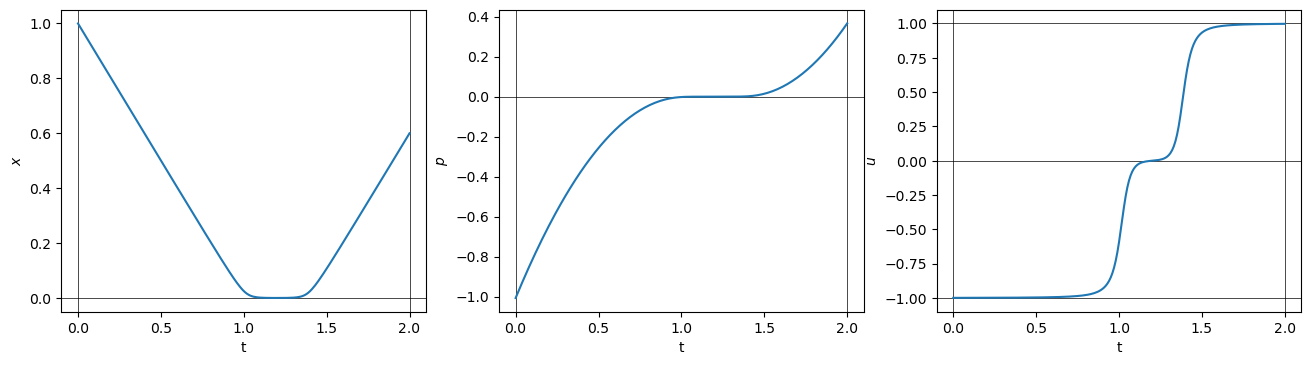

In [15]:
# Plot final solution
if(np.abs(sol_path.parsf[2]-e_final)<1e-5):
    plotSolution(sol_path.xf, e_final, tf_final)
else:
    print('Homotopy not complete')

## III) Resolution of the optimal control problem by multiple shooting

We come back to the original optimal control problem:

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \int_0^{t_f} x^2(t) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) = f(x(t), u(t)) := \displaystyle u(t), \quad  |u(t)| \le 1, \quad t \in [0, t_f] \text{ a.e.},    \\[1.0em]
        x(0) = 1, \quad x(t_f) = 1/2.
    \end{array}
    \right. 
$$

We have determined that the optimal control follows the strategy:

$$
    u(t) = \left\{ 
    \begin{array}{lll}
        -1            & \text{if} & t \in [0, t_1],     \\[0.5em]
        \phantom{-}0  & \text{if} & t \in (t_1, t_2],   \\[0.5em]
        +1            & \text{if} & t \in (t_2, t_f],
    \end{array}
    \right. 
$$

with $0 < t_1 < t_2 < t_f=2$. 


<div class="alert alert-warning">

**Goal**

The goal is to find the values of the switching times $t_1$ and $t_2$ together with the initial covector $p_0$ (see Remark 2).
    
</div>

### Maximized Hamiltonian and its derivatives

We define first the three control laws $u \equiv \{-1, 0, 1\}$.

In [16]:
# Controls in feedback form
@tools.vectorize(vvars=(1, 2, 3))
def uplus(t, x, p):
    u = +1.0
    return u

@tools.vectorize(vvars=(1, 2, 3))
def uminus(t, x, p):
    u = -1.0
    return u

@tools.vectorize(vvars=(1, 2, 3))
def using(t, x, p):
    u = 0.0
    return u

The pseudo-Hamiltonian is

$$
    H(x,p,u) = pu - x^2.
$$

In [17]:
# Definition of the Hamiltonian and its derivatives for u = 1
#
def dhfunplus(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    u  = uplus(t, x, p)
    hd = u*dp - 2.0*x*dx
    return hd
    
def d2hfunplus(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd    = -2.0 * d2x * dx
    return hdd

@tools.tensorize(dhfunplus, d2hfunplus, tvars=(2, 3))
def hfunplus(t, x, p):
    u = uplus(t, x, p)
    h = p*u - x**2
    return h

hplus = ocp.Hamiltonian(hfunplus)
fplus = ocp.Flow(hplus)

We give the Hamiltonians for $u=-1$ and $u=0$ with their derivatives.

In [18]:
# Definition of the Hamiltonian and its derivatives for u = -1
def dhfunminus(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    u  = uminus(t, x, p)
    hd = u*dp - 2.0*x*dx
    return hd
    
def d2hfunminus(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd    = -2.0 * d2x * dx
    return hdd

@tools.tensorize(dhfunminus, d2hfunminus, tvars=(2, 3))
def hfunminus(t, x, p):
    u = uminus(t, x, p)
    h = p*u - x**2
    return h

hminus = ocp.Hamiltonian(hfunminus)
fminus = ocp.Flow(hminus)

### Shooting function

The multiple shooting function is given by

$$
 S(t_1, t_2) := 
 \begin{pmatrix}
     x(t_0, t_1, 0, 0, u_-) - 1       \\
     x(t_f, t_2, 0, 0, u_+) - 1/2
 \end{pmatrix},
$$

where z(t, s, a, b, u) is the solution at time $t$ of the Hamiltonian system associated to the control u starting at time $s$ at the initial condition $z(s) = (a,b)$.

We have introduced the notation $u_-$ for $u\equiv -1$ and $u_+$ for $u\equiv +1$.

**_Remark:_** We know that $(x(t_1), p(t_1))=(x(t_2), p(t_2))=(0,0)$.

In [19]:
# Multiple shooting function
#

tf = tf_final # we set the final time to the value tf_final

def shoot_multiple(y):
    t1 = y[0]
    t2 = y[1]
    
    zero = np.zeros([1,])
    xi, pi = fminus(t1, zero, zero, t0)  # on [t1, t0]
    xf, pf =  fplus(t2, zero, zero, tf)  # on [t2, tf]
    
    s = np.zeros([2])
    s[0] = xi[0] - x0[0]
    s[1] = xf[0] - xf_target[0]  # x(tf, x0, p0) - xf_target
    return s

### Resolution of the shooting function

In [20]:
# Initial guess for the Newton solver
t1_guess = 0.9
t2_guess = 1.6

In [21]:
# Resolution of the shooting function
y_guess  = np.array([t1_guess, t2_guess])
sol_nle_mul  = nt.nle.solve(shoot_multiple, y_guess)


     Calls  |f(x)|                 |x|
 
         1  1.414213562373096e-01  1.835755975068582e+00
         2  5.058608532060305e-10  1.802775638152897e+00
         3  1.110223024625157e-16  1.802775637731995e+00

 Results of the nle solver method:

 xsol    =  [1.  1.5]
 f(xsol) =  [0.00000000e+00 1.11022302e-16]
 nfev    =  3
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.



In [22]:
# function to plot solution

def plotSolutionBSB(t1, t2, tf):

    N      = 20
    
    tspan1  = list(np.linspace(t1, t0, N+1))
    tspan2  = (t1, t2)
    tspanf  = list(np.linspace(t2, tf, N+1))
        
    zero    = np.zeros([1,])
    
    x1, p1 = fminus(t1, zero, zero, tspan1)  # on [ 0, t1]
    x2     = np.array([zero, zero])
    p2     = np.array([zero, zero])
    xf, pf = fplus(t2, zero, zero, tspanf)  # on [t2, tf]
    
    u1     = uminus(tspan1, x1, p1)
    u2     = np.array([0., 0.])
    uf     =  uplus(tspanf, xf, pf)

    fig = plt.figure()
    
    ax  = fig.add_subplot(131);
    ax.set_xlabel('t'); ax.set_ylabel('$x$'); ax.axhline(0, color='k', linewidth=0.5); 
    ax.axvline( 0, color='k', linewidth=0.5); ax.axvline( tf, color='k', linewidth=0.5)
    ax.plot(np.concatenate((np.flip(tspan1), tspan2, tspanf)), np.concatenate((np.flip(x1), x2, xf)))
    
    ax  = fig.add_subplot(132);
    ax.set_xlabel('t'); ax.set_ylabel('$p$'); ax.axhline(0, color='k', linewidth=0.5); 
    ax.axvline( 0, color='k', linewidth=0.5); ax.axvline( tf, color='k', linewidth=0.5)
    ax.plot(np.concatenate((np.flip(tspan1), tspan2, tspanf)), np.concatenate((np.flip(p1), p2, pf)))
    
    ax  = fig.add_subplot(133);
    ax.set_xlabel('t'); ax.set_ylabel('$u$'); ax.axhline(0, color='k', linewidth=0.5); 
    ax.axvline( 0, color='k', linewidth=0.5)
    ax.axvline( tf, color='k', linewidth=0.5)
    ax.axhline(-1, color='k', linewidth=0.5)
    ax.axhline( 1, color='k', linewidth=0.5)
    ax.plot(np.concatenate((np.flip(tspan1), tspan2, tspanf)), np.concatenate((np.flip(u1), u2, uf)))

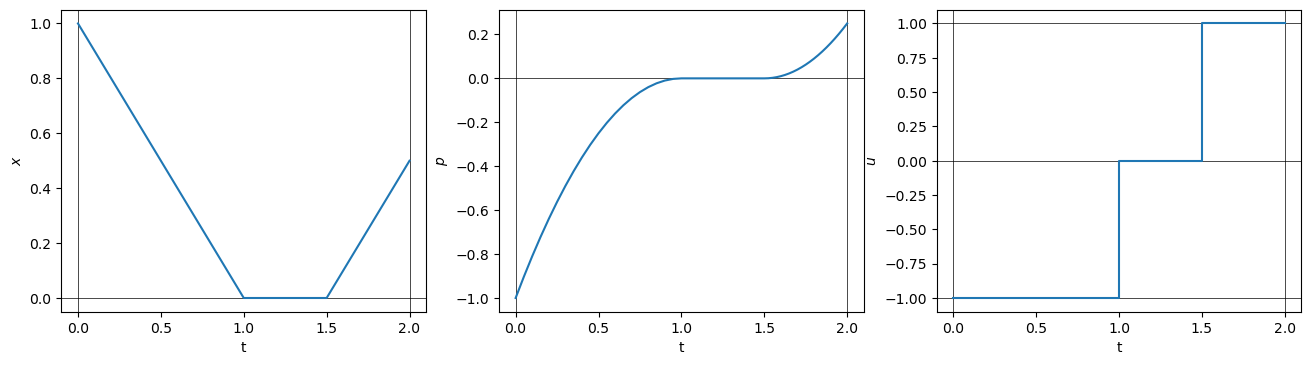

In [23]:
# plot solution
t1 = sol_nle_mul.x[0]
t2 = sol_nle_mul.x[1]
plotSolutionBSB(t1, t2, tf)

[thumbnail](bsb_turnpike_1d.png)